# Binary Classification Model for MiniBooNE Particle Identification Using Python Take 6
### David Lowe
### November 25, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The MiniBooNE Particle Identification dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: This dataset is taken from the MiniBooNE experiment and is used to distinguish electron neutrinos (signal) from muon neutrinos (background). The data file is set up as follows. In the first line is the number of signal events followed by the number of background events. The records with the signal events come first, followed by the background events. Each line, after the first line, has the 50 particle ID variables for one event.

For this iteration, we will leverage TPOT, the automated machine learning tool got Python, that optimizes machine learning pipelines using genetic programming.

ANALYSIS: The baseline performance of the machine learning algorithms achieved the best accuracy of 91.11% after generation one. After generation 20, Gradient Boosting turned in the top overall result and achieved an accuracy metric of 92.44%. Furthermore, the Gradient Boosting algorithm processed the testing dataset with an accuracy of 92.83%, which was even better than the prediction result from the training data.

CONCLUSION: For this iteration, the Gradient Boosting algorithm achieved the best overall results using the training and test datasets. For this dataset, Gradient Boosting should be considered for further modeling.

Dataset Used: MiniBooNE Particle Identification Data Set

Dataset ML Model: Binary classification with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/MiniBooNE+particle+identification

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Environment

### 1.a) Load libraries and modules

In [39]:
# Set the warning message filter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [40]:
# Set the random seed number for reproducible results
seedNum = 888

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import re
from datetime import datetime
from email.message import EmailMessage
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier
from tpot import TPOTClassifier

### 1.b) Set up the controlling parameters and functions

In [42]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set the number of folds for cross validation
n_folds = 10

# Set various default modeling parameters
scoring = 'accuracy'
# scoring = 'roc_auc'

In [43]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Binary Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [44]:
if (notifyStatus): email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [45]:
dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00199/MiniBooNE_PID.txt'

signal_rec = 36499
widthVector = [14] * 50
colNames = ["particle" + str(i).zfill(2) for i in range(1,51)]
Xy_original = pd.read_fwf(dataset_path, widths=widthVector, header=None, names=colNames, skiprows=1, index_col=False, na_values=[-999])
Xy_original['targetVar'] = 0
Xy_original.iloc[:signal_rec, len(Xy_original.columns)-1] = 1

# Take a peek at the dataframe after import
Xy_original.head(10)

,particle01,particle02,particle03,particle04,particle05,particle06,particle07,particle08,particle09,particle10,...,particle42,particle43,particle44,particle45,particle46,particle47,particle48,particle49,particle50,targetVar
0,2.59413,0.468803,20.69160,0.322648,0.009682,0.374393,0.803479,0.896592,3.59665,0.249282,...,-31.3730,0.442259,5.86453,0.000000,0.090519,0.176909,0.457585,0.071769,0.245996,1
1,3.86388,0.645781,18.13750,0.233529,0.030733,0.361239,1.069740,0.878714,3.59243,0.200793,...,45.9597,-0.478507,6.11126,0.001182,0.091800,-0.465572,0.935523,0.333613,0.230621,1
2,3.38584,1.197140,36.08070,0.200866,0.017341,0.260841,1.108950,0.884405,3.43159,0.177167,...,-11.5608,-0.297008,8.27204,0.003854,0.141721,-0.210559,1.013450,0.255512,0.180901,1
3,4.28524,0.510155,674.20100,0.281923,0.009174,0.000000,0.998822,0.823390,3.16382,0.171678,...,-18.4586,0.453886,2.48112,0.000000,0.180938,0.407968,4.341270,0.473081,0.258990,1
4,5.93662,0.832993,59.87960,0.232853,0.025066,0.233556,1.370040,0.787424,3.66546,0.174862,...,42.9600,-0.975752,2.66109,0.000000,0.170836,-0.814403,4.679490,1.924990,0.253893,1
5,4.41251,2.157210,66.78530,0.335389,0.004274,0.133690,0.696868,0.753386,3.45575,0.150908,...,-18.5469,0.638310,5.97304,0.000000,0.156063,0.458479,3.500280,3.616290,0.189857,1
6,3.41292,0.834852,45.59630,0.253942,0.009479,0.290691,1.273870,0.891223,3.42853,0.227561,...,-11.3654,0.060045,4.85395,0.000000,0.102631,-0.036952,0.862529,0.671407,0.254095,1
7,2.93345,0.243213,9.73308,0.243312,0.018536,0.516637,1.188590,0.904027,3.38835,0.240489,...,-25.0214,0.015407,4.66803,0.001854,0.108072,-0.149434,0.451253,-0.182719,0.229547,1
8,4.10757,0.682600,83.69250,0.263911,0.005181,0.168942,1.403150,0.889605,3.26032,0.187648,...,-11.0120,0.566295,4.06860,0.000000,0.181448,0.265645,1.500240,0.457965,0.207168,1
9,3.82959,0.507140,29.43650,0.240391,0.010465,0.284973,1.305070,0.898304,3.05597,0.197686,...,16.6402,0.567033,1.72581,0.000000,0.195321,0.106837,2.030230,0.188336,0.296247,1


In [46]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130064 entries, 0 to 130063
Data columns (total 51 columns):
particle01    129596 non-null float64
particle02    129596 non-null float64
particle03    129596 non-null float64
particle04    129596 non-null float64
particle05    129596 non-null float64
particle06    129596 non-null float64
particle07    129596 non-null float64
particle08    129596 non-null float64
particle09    129596 non-null float64
particle10    129596 non-null float64
particle11    129596 non-null float64
particle12    129596 non-null float64
particle13    129596 non-null float64
particle14    129596 non-null float64
particle15    129596 non-null float64
particle16    129596 non-null float64
particle17    129596 non-null float64
particle18    129596 non-null float64
particle19    129596 non-null float64
particle20    129596 non-null float64
particle21    129596 non-null float64
particle22    129596 non-null float64
particle23    129596 non-null float64
particle24    1

In [47]:
Xy_original.describe()

,particle01,particle02,particle03,particle04,particle05,particle06,particle07,particle08,particle09,particle10,...,particle42,particle43,particle44,particle45,particle46,particle47,particle48,particle49,particle50,targetVar
count,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,...,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,130064.000000
mean,4.863931,1.492450,127.849703,0.283131,0.009311,0.160797,0.970221,0.823904,3.451369,0.173899,...,-21.709448,0.733346,6.009403,0.009058,0.178782,-0.159174,2.859957,1.613380,0.230708,0.280623
std,1.161277,0.860538,184.363509,0.059554,0.012493,0.122911,0.342953,0.070467,0.258654,0.043707,...,33.858218,1.224392,4.562213,0.029533,0.080407,0.977600,1.917000,1.960976,0.052818,0.449306
min,0.000000,0.059691,0.012381,0.104697,-0.156118,0.000000,0.000000,0.033510,2.375270,0.033432,...,-387.617000,-1.686500,0.249186,0.000000,0.000000,-32.109800,-13.492200,-15.997800,0.000000,0.000000
25%,4.021948,0.882372,49.978850,0.241901,0.001245,0.086348,0.717548,0.783985,3.286500,0.143172,...,-39.847675,-0.022607,3.428092,0.000000,0.122498,-0.336228,1.430775,0.281640,0.197748,0.000000
50%,4.793385,1.385640,106.423000,0.272313,0.005013,0.141468,0.924166,0.834244,3.427935,0.170756,...,-21.456250,0.462485,4.772420,0.000000,0.168887,0.043698,2.372290,1.130715,0.231553,0.000000
75%,5.632045,1.950260,138.994000,0.315312,0.013183,0.213450,1.181228,0.874354,3.586220,0.200121,...,-3.254285,1.153780,6.869710,0.002000,0.224994,0.295472,3.784865,2.286112,0.263353,1.000000
max,17.057300,8.802820,4747.670000,0.736804,0.179012,0.703859,6.241080,0.989713,7.170170,0.524888,...,161.298000,43.651200,85.823100,0.446914,0.605667,1.932890,21.768200,25.423300,0.625484,1.000000


In [48]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

particle01    468
particle02    468
particle03    468
particle04    468
particle05    468
particle06    468
particle07    468
particle08    468
particle09    468
particle10    468
particle11    468
particle12    468
particle13    468
particle14    468
particle15    468
particle16    468
particle17    468
particle18    468
particle19    468
particle20    468
particle21    468
particle22    468
particle23    468
particle24    468
particle25    468
particle26    468
particle27    468
particle28    468
particle29    468
particle30    468
particle31    468
particle32    468
particle33    468
particle34    468
particle35    468
particle36    468
particle37    468
particle38    468
particle39    468
particle40    468
particle41    468
particle42    468
particle43    468
particle44    468
particle45    468
particle46    468
particle47    468
particle48    468
particle49    468
particle50    468
targetVar       0
dtype: int64
Total number of NaN in the dataframe:  23400


### 1.d) Data Cleaning

In [49]:
# Dropping rows with NA's
Xy_original.dropna(axis=0, inplace=True)

# Take a peek at the dataframe after cleaning
Xy_original.head(10)

,particle01,particle02,particle03,particle04,particle05,particle06,particle07,particle08,particle09,particle10,...,particle42,particle43,particle44,particle45,particle46,particle47,particle48,particle49,particle50,targetVar
0,2.59413,0.468803,20.69160,0.322648,0.009682,0.374393,0.803479,0.896592,3.59665,0.249282,...,-31.3730,0.442259,5.86453,0.000000,0.090519,0.176909,0.457585,0.071769,0.245996,1
1,3.86388,0.645781,18.13750,0.233529,0.030733,0.361239,1.069740,0.878714,3.59243,0.200793,...,45.9597,-0.478507,6.11126,0.001182,0.091800,-0.465572,0.935523,0.333613,0.230621,1
2,3.38584,1.197140,36.08070,0.200866,0.017341,0.260841,1.108950,0.884405,3.43159,0.177167,...,-11.5608,-0.297008,8.27204,0.003854,0.141721,-0.210559,1.013450,0.255512,0.180901,1
3,4.28524,0.510155,674.20100,0.281923,0.009174,0.000000,0.998822,0.823390,3.16382,0.171678,...,-18.4586,0.453886,2.48112,0.000000,0.180938,0.407968,4.341270,0.473081,0.258990,1
4,5.93662,0.832993,59.87960,0.232853,0.025066,0.233556,1.370040,0.787424,3.66546,0.174862,...,42.9600,-0.975752,2.66109,0.000000,0.170836,-0.814403,4.679490,1.924990,0.253893,1
5,4.41251,2.157210,66.78530,0.335389,0.004274,0.133690,0.696868,0.753386,3.45575,0.150908,...,-18.5469,0.638310,5.97304,0.000000,0.156063,0.458479,3.500280,3.616290,0.189857,1
6,3.41292,0.834852,45.59630,0.253942,0.009479,0.290691,1.273870,0.891223,3.42853,0.227561,...,-11.3654,0.060045,4.85395,0.000000,0.102631,-0.036952,0.862529,0.671407,0.254095,1
7,2.93345,0.243213,9.73308,0.243312,0.018536,0.516637,1.188590,0.904027,3.38835,0.240489,...,-25.0214,0.015407,4.66803,0.001854,0.108072,-0.149434,0.451253,-0.182719,0.229547,1
8,4.10757,0.682600,83.69250,0.263911,0.005181,0.168942,1.403150,0.889605,3.26032,0.187648,...,-11.0120,0.566295,4.06860,0.000000,0.181448,0.265645,1.500240,0.457965,0.207168,1
9,3.82959,0.507140,29.43650,0.240391,0.010465,0.284973,1.305070,0.898304,3.05597,0.197686,...,16.6402,0.567033,1.72581,0.000000,0.195321,0.106837,2.030230,0.188336,0.296247,1


In [50]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129596 entries, 0 to 130063
Data columns (total 51 columns):
particle01    129596 non-null float64
particle02    129596 non-null float64
particle03    129596 non-null float64
particle04    129596 non-null float64
particle05    129596 non-null float64
particle06    129596 non-null float64
particle07    129596 non-null float64
particle08    129596 non-null float64
particle09    129596 non-null float64
particle10    129596 non-null float64
particle11    129596 non-null float64
particle12    129596 non-null float64
particle13    129596 non-null float64
particle14    129596 non-null float64
particle15    129596 non-null float64
particle16    129596 non-null float64
particle17    129596 non-null float64
particle18    129596 non-null float64
particle19    129596 non-null float64
particle20    129596 non-null float64
particle21    129596 non-null float64
particle22    129596 non-null float64
particle23    129596 non-null float64
particle24    1

In [51]:
Xy_original.describe()

,particle01,particle02,particle03,particle04,particle05,particle06,particle07,particle08,particle09,particle10,...,particle42,particle43,particle44,particle45,particle46,particle47,particle48,particle49,particle50,targetVar
count,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,...,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000
mean,4.863931,1.492450,127.849703,0.283131,0.009311,0.160797,0.970221,0.823904,3.451369,0.173899,...,-21.709448,0.733346,6.009403,0.009058,0.178782,-0.159174,2.859957,1.613380,0.230708,0.281552
std,1.161277,0.860538,184.363509,0.059554,0.012493,0.122911,0.342953,0.070467,0.258654,0.043707,...,33.858218,1.224392,4.562213,0.029533,0.080407,0.977600,1.917000,1.960976,0.052818,0.449758
min,0.000000,0.059691,0.012381,0.104697,-0.156118,0.000000,0.000000,0.033510,2.375270,0.033432,...,-387.617000,-1.686500,0.249186,0.000000,0.000000,-32.109800,-13.492200,-15.997800,0.000000,0.000000
25%,4.021948,0.882372,49.978850,0.241901,0.001245,0.086348,0.717548,0.783985,3.286500,0.143172,...,-39.847675,-0.022607,3.428092,0.000000,0.122498,-0.336228,1.430775,0.281640,0.197748,0.000000
50%,4.793385,1.385640,106.423000,0.272313,0.005013,0.141468,0.924166,0.834244,3.427935,0.170756,...,-21.456250,0.462485,4.772420,0.000000,0.168887,0.043698,2.372290,1.130715,0.231553,0.000000
75%,5.632045,1.950260,138.994000,0.315312,0.013183,0.213450,1.181228,0.874354,3.586220,0.200121,...,-3.254285,1.153780,6.869710,0.002000,0.224994,0.295472,3.784865,2.286112,0.263353,1.000000
max,17.057300,8.802820,4747.670000,0.736804,0.179012,0.703859,6.241080,0.989713,7.170170,0.524888,...,161.298000,43.651200,85.823100,0.446914,0.605667,1.932890,21.768200,25.423300,0.625484,1.000000


In [52]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

particle01    0
particle02    0
particle03    0
particle04    0
particle05    0
particle06    0
particle07    0
particle08    0
particle09    0
particle10    0
particle11    0
particle12    0
particle13    0
particle14    0
particle15    0
particle16    0
particle17    0
particle18    0
particle19    0
particle20    0
particle21    0
particle22    0
particle23    0
particle24    0
particle25    0
particle26    0
particle27    0
particle28    0
particle29    0
particle30    0
particle31    0
particle32    0
particle33    0
particle34    0
particle35    0
particle36    0
particle37    0
particle38    0
particle39    0
particle40    0
particle41    0
particle42    0
particle43    0
particle44    0
particle45    0
particle46    0
particle47    0
particle48    0
particle49    0
particle50    0
targetVar     0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Attribute-only and Target-only Sets

In [53]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [54]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (129596, 51) X_original.shape: (129596, 50) y_original.shape: (129596,)


### 1.f) Set up the parameters for data visualization

In [55]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [56]:
if (notifyStatus): email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [57]:
if (notifyStatus): email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [58]:
X_original.head(10)

,particle01,particle02,particle03,particle04,particle05,particle06,particle07,particle08,particle09,particle10,...,particle41,particle42,particle43,particle44,particle45,particle46,particle47,particle48,particle49,particle50
0,2.59413,0.468803,20.69160,0.322648,0.009682,0.374393,0.803479,0.896592,3.59665,0.249282,...,101.174,-31.3730,0.442259,5.86453,0.000000,0.090519,0.176909,0.457585,0.071769,0.245996
1,3.86388,0.645781,18.13750,0.233529,0.030733,0.361239,1.069740,0.878714,3.59243,0.200793,...,186.516,45.9597,-0.478507,6.11126,0.001182,0.091800,-0.465572,0.935523,0.333613,0.230621
2,3.38584,1.197140,36.08070,0.200866,0.017341,0.260841,1.108950,0.884405,3.43159,0.177167,...,129.931,-11.5608,-0.297008,8.27204,0.003854,0.141721,-0.210559,1.013450,0.255512,0.180901
3,4.28524,0.510155,674.20100,0.281923,0.009174,0.000000,0.998822,0.823390,3.16382,0.171678,...,163.978,-18.4586,0.453886,2.48112,0.000000,0.180938,0.407968,4.341270,0.473081,0.258990
4,5.93662,0.832993,59.87960,0.232853,0.025066,0.233556,1.370040,0.787424,3.66546,0.174862,...,229.555,42.9600,-0.975752,2.66109,0.000000,0.170836,-0.814403,4.679490,1.924990,0.253893
5,4.41251,2.157210,66.78530,0.335389,0.004274,0.133690,0.696868,0.753386,3.45575,0.150908,...,153.943,-18.5469,0.638310,5.97304,0.000000,0.156063,0.458479,3.500280,3.616290,0.189857
6,3.41292,0.834852,45.59630,0.253942,0.009479,0.290691,1.273870,0.891223,3.42853,0.227561,...,137.419,-11.3654,0.060045,4.85395,0.000000,0.102631,-0.036952,0.862529,0.671407,0.254095
7,2.93345,0.243213,9.73308,0.243312,0.018536,0.516637,1.188590,0.904027,3.38835,0.240489,...,148.262,-25.0214,0.015407,4.66803,0.001854,0.108072,-0.149434,0.451253,-0.182719,0.229547
8,4.10757,0.682600,83.69250,0.263911,0.005181,0.168942,1.403150,0.889605,3.26032,0.187648,...,151.280,-11.0120,0.566295,4.06860,0.000000,0.181448,0.265645,1.500240,0.457965,0.207168
9,3.82959,0.507140,29.43650,0.240391,0.010465,0.284973,1.305070,0.898304,3.05597,0.197686,...,163.690,16.6402,0.567033,1.72581,0.000000,0.195321,0.106837,2.030230,0.188336,0.296247


#### 2.a.ii) Dimensions and attribute types

In [59]:
X_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129596 entries, 0 to 130063
Data columns (total 50 columns):
particle01    129596 non-null float64
particle02    129596 non-null float64
particle03    129596 non-null float64
particle04    129596 non-null float64
particle05    129596 non-null float64
particle06    129596 non-null float64
particle07    129596 non-null float64
particle08    129596 non-null float64
particle09    129596 non-null float64
particle10    129596 non-null float64
particle11    129596 non-null float64
particle12    129596 non-null float64
particle13    129596 non-null float64
particle14    129596 non-null float64
particle15    129596 non-null float64
particle16    129596 non-null float64
particle17    129596 non-null float64
particle18    129596 non-null float64
particle19    129596 non-null float64
particle20    129596 non-null float64
particle21    129596 non-null float64
particle22    129596 non-null float64
particle23    129596 non-null float64
particle24    1

#### 2.a.iii) Statistical summary of the attributes

In [60]:
X_original.describe()

,particle01,particle02,particle03,particle04,particle05,particle06,particle07,particle08,particle09,particle10,...,particle41,particle42,particle43,particle44,particle45,particle46,particle47,particle48,particle49,particle50
count,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,...,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000
mean,4.863931,1.492450,127.849703,0.283131,0.009311,0.160797,0.970221,0.823904,3.451369,0.173899,...,145.297502,-21.709448,0.733346,6.009403,0.009058,0.178782,-0.159174,2.859957,1.613380,0.230708
std,1.161277,0.860538,184.363509,0.059554,0.012493,0.122911,0.342953,0.070467,0.258654,0.043707,...,31.766619,33.858218,1.224392,4.562213,0.029533,0.080407,0.977600,1.917000,1.960976,0.052818
min,0.000000,0.059691,0.012381,0.104697,-0.156118,0.000000,0.000000,0.033510,2.375270,0.033432,...,33.895200,-387.617000,-1.686500,0.249186,0.000000,0.000000,-32.109800,-13.492200,-15.997800,0.000000
25%,4.021948,0.882372,49.978850,0.241901,0.001245,0.086348,0.717548,0.783985,3.286500,0.143172,...,123.193000,-39.847675,-0.022607,3.428092,0.000000,0.122498,-0.336228,1.430775,0.281640,0.197748
50%,4.793385,1.385640,106.423000,0.272313,0.005013,0.141468,0.924166,0.834244,3.427935,0.170756,...,145.538500,-21.456250,0.462485,4.772420,0.000000,0.168887,0.043698,2.372290,1.130715,0.231553
75%,5.632045,1.950260,138.994000,0.315312,0.013183,0.213450,1.181228,0.874354,3.586220,0.200121,...,167.179250,-3.254285,1.153780,6.869710,0.002000,0.224994,0.295472,3.784865,2.286112,0.263353
max,17.057300,8.802820,4747.670000,0.736804,0.179012,0.703859,6.241080,0.989713,7.170170,0.524888,...,331.925000,161.298000,43.651200,85.823100,0.446914,0.605667,1.932890,21.768200,25.423300,0.625484


#### 2.a.iv) Summarize the levels of the class attribute

In [61]:
Xy_original.groupby('targetVar').size()

targetVar
0    93108
1    36488
dtype: int64

### 2.b) Data Visualization

##### 2.b.i) Univariate plots to better understand each attribute

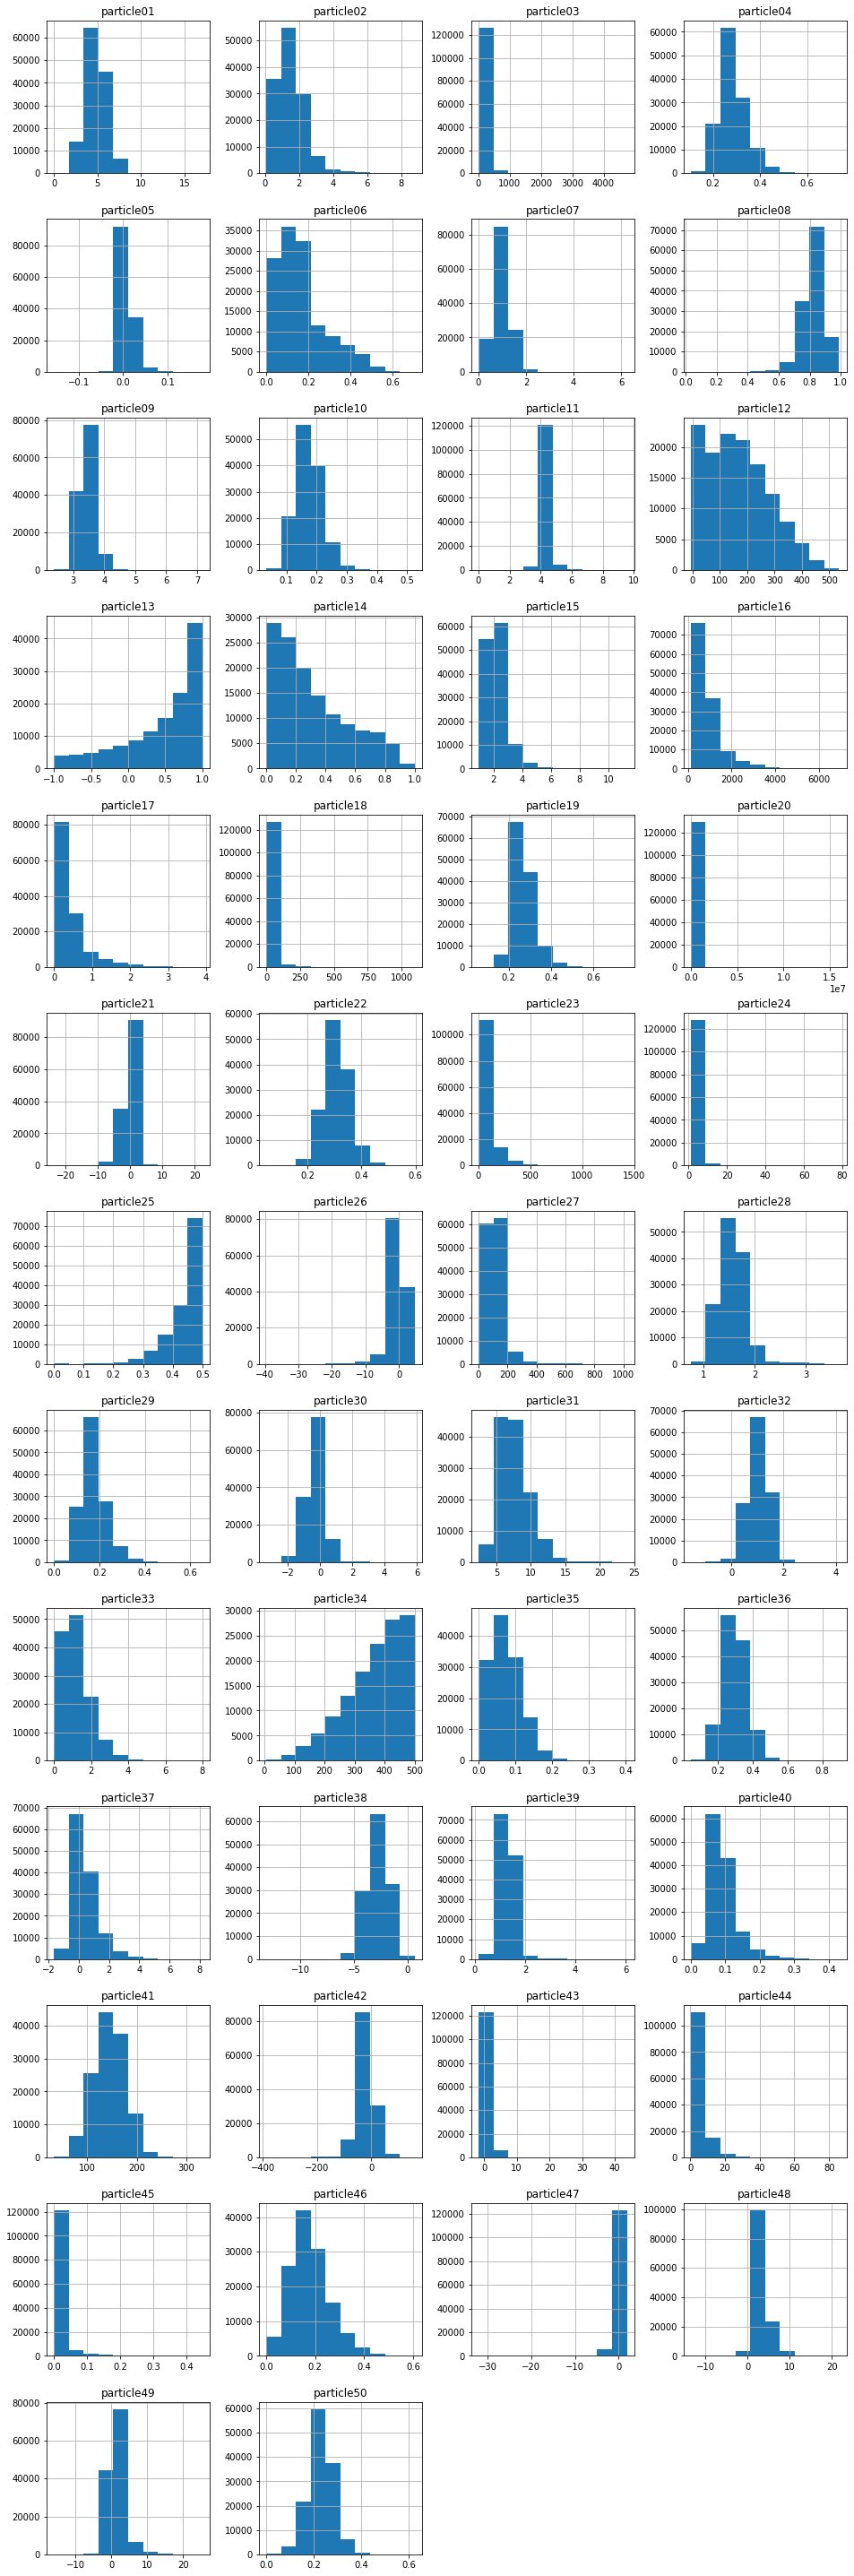

In [62]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

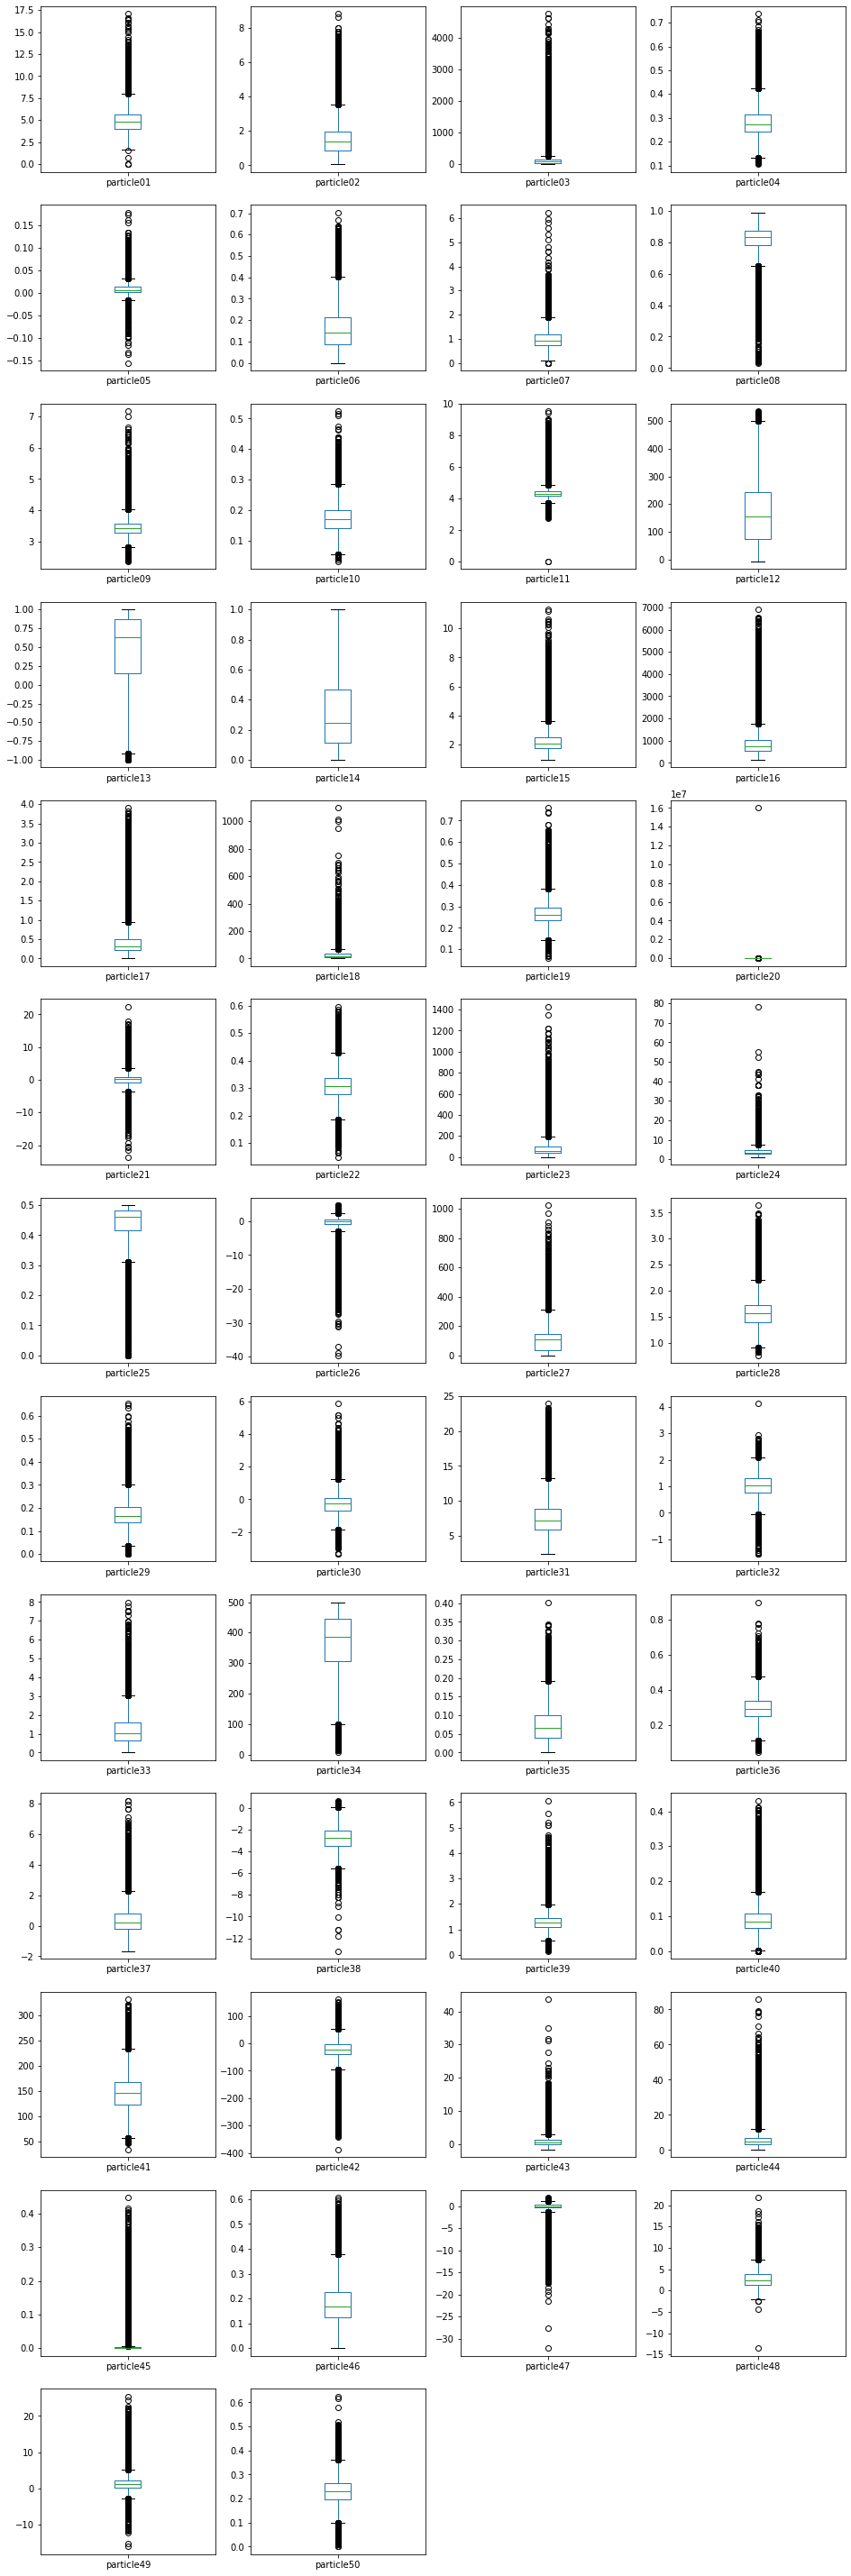

In [63]:
# Box and Whisker plot for each attribute
X_original.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

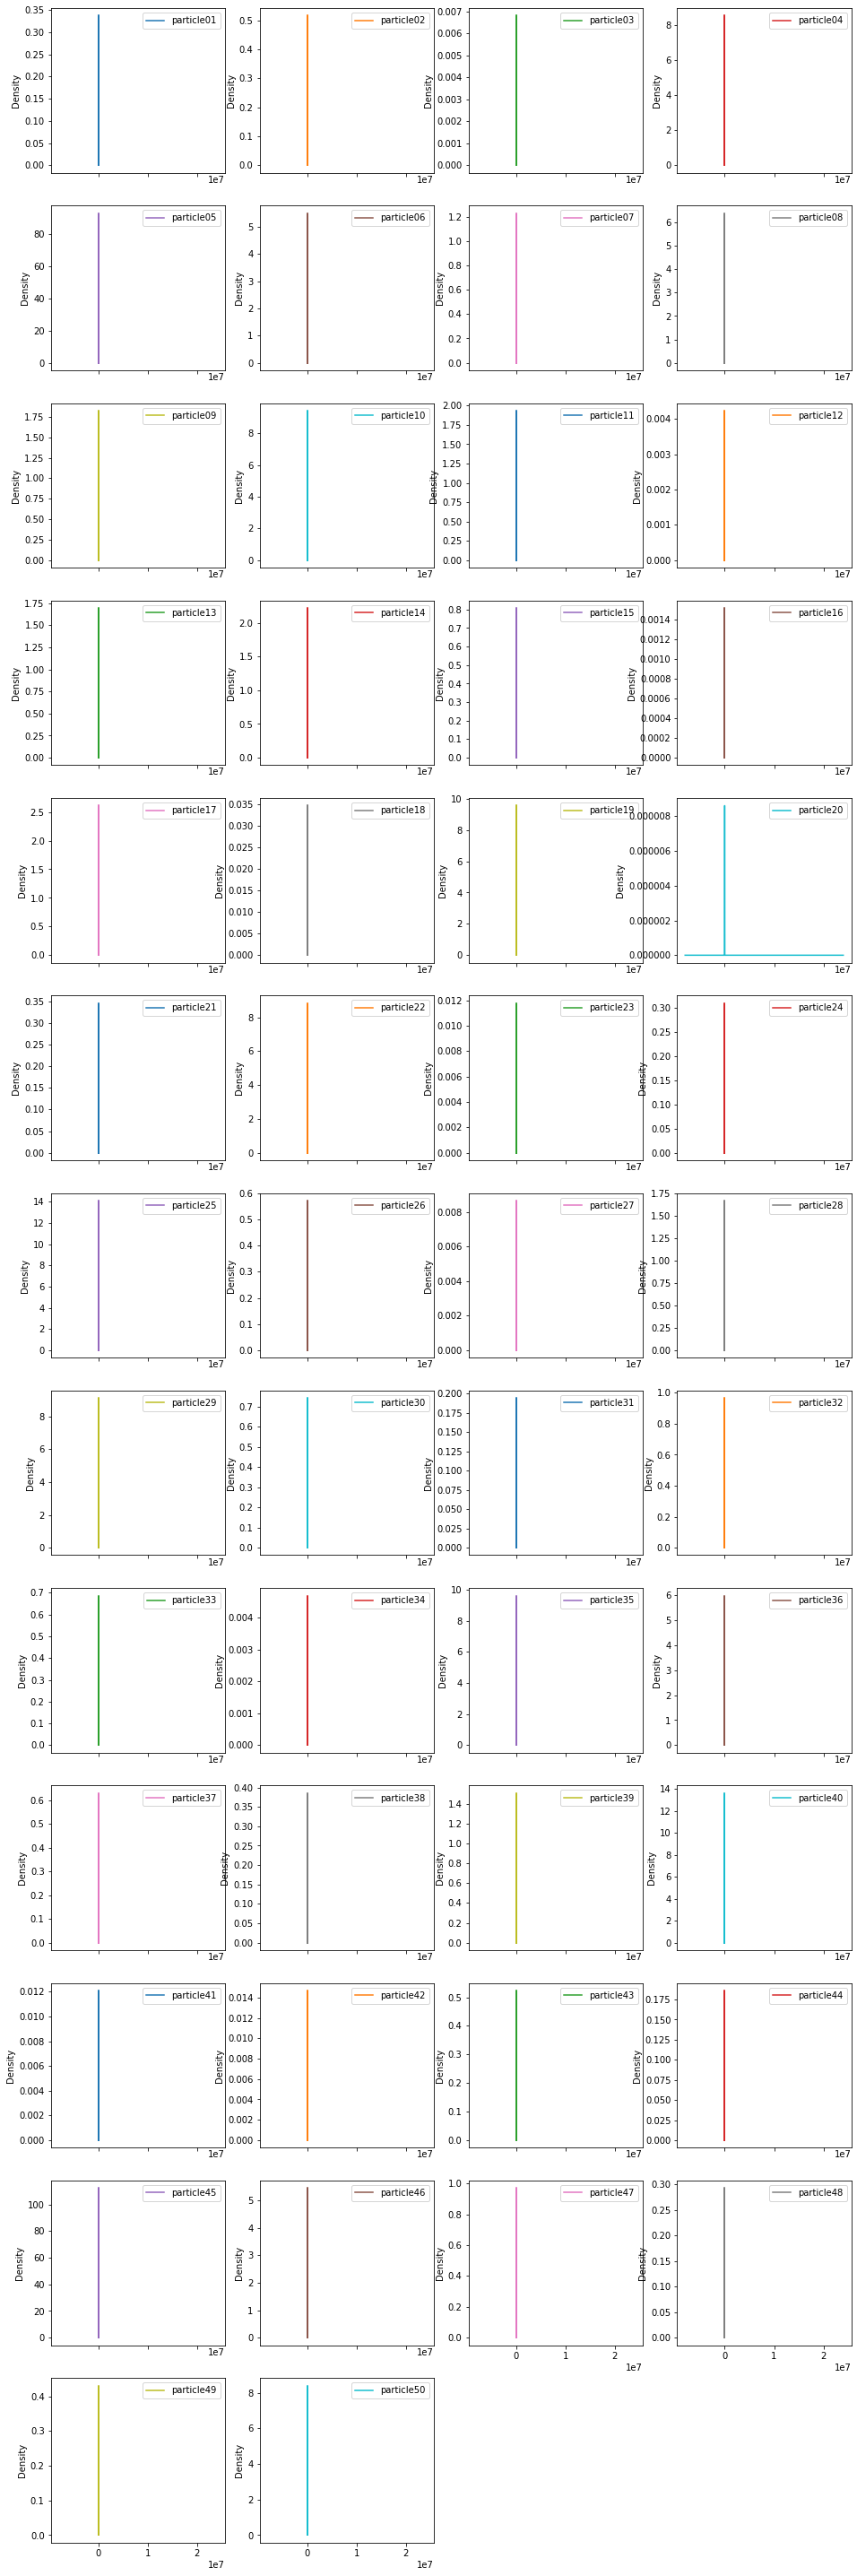

In [64]:
# Density plot for each attribute
X_original.plot(kind='density', subplots=True, layout=(dispRow,dispCol))
plt.show()

#### 2.b.ii) Multivariate plots to better understand the relationships between attributes

In [65]:
# Scatterplot matrix
# scatter_matrix(X_original)
# plt.show()

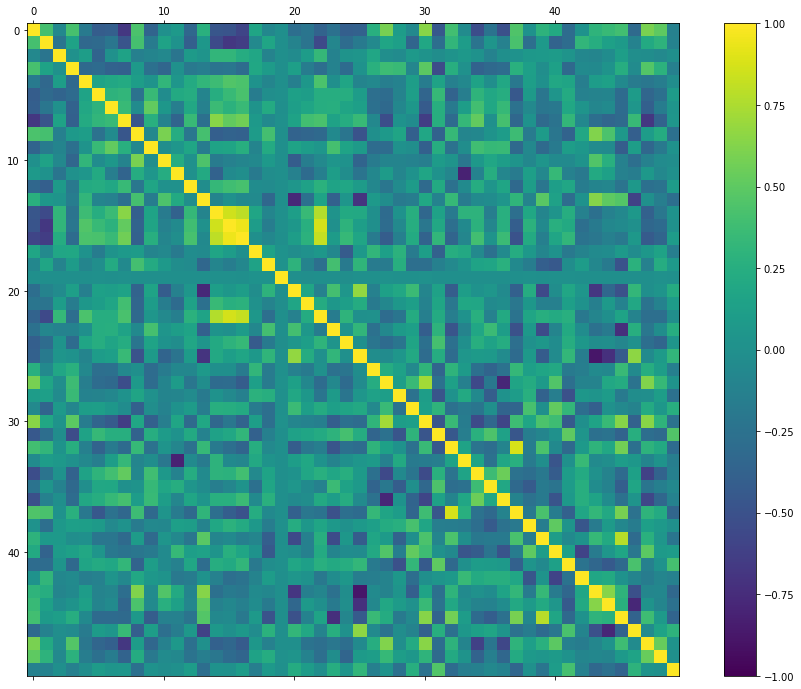

In [66]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_original.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [67]:
if (notifyStatus): email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [68]:
if (notifyStatus): email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [69]:
# Apply feature scaling techniques

# X_original = X_original.astype(float)
# X_original['some_feature'] = preprocessing.scale(X_original['some_feature'])
preprocessing.scale(X_original, copy=False)
# X_original['some_feature'] = preprocessing.minmax_scale(X_original['some_feature'])
# preprocessing.minmax_scale(X_original, copy=False)
# X_original['some_feature'] = preprocessing.normalize(X_original['some_feature'])
# preprocessing.normalize(X_original, copy=False)
# X_original['some_feature'] = preprocessing.robust_scale(X_original['some_feature'])
# preprocessing.robust_scale(X_original, copy=False)
# X_original['some_feature'] = preprocessing.power_transform(X_original['some_feature'])
# preprocessing.power_transform(X_original, copy=False)
print(X_original.head(-10))

        particle01  particle02  particle03  particle04  particle05  \
0        -1.954580   -1.189547   -0.581235    0.663547    0.029684   
1        -0.861168   -0.983886   -0.595089   -0.832887    1.714776   
2        -1.272820   -0.343170   -0.497763   -1.381345    0.642781   
3        -0.498325   -1.141493    2.963457   -0.020284   -0.010946   
4         0.923718   -0.766333   -0.368676   -0.844238    1.261152   
...            ...         ...         ...         ...         ...   
130049    0.949879    0.807800    0.031532   -1.364016    0.525271   
130050    0.704829    0.930317   -0.209467    0.632029   -0.745331   
130051    0.376215   -0.591584    0.146414   -0.054807    0.055149   
130052    0.521143   -0.258374    0.218028    0.673655   -0.122389   
130053   -0.076460   -0.173426   -0.026679    0.336719   -0.745331   

        particle06  particle07  particle08  particle09  particle10  ...  \
0         1.737819   -0.486195    1.031514    0.561684    1.724753  ...   
1        

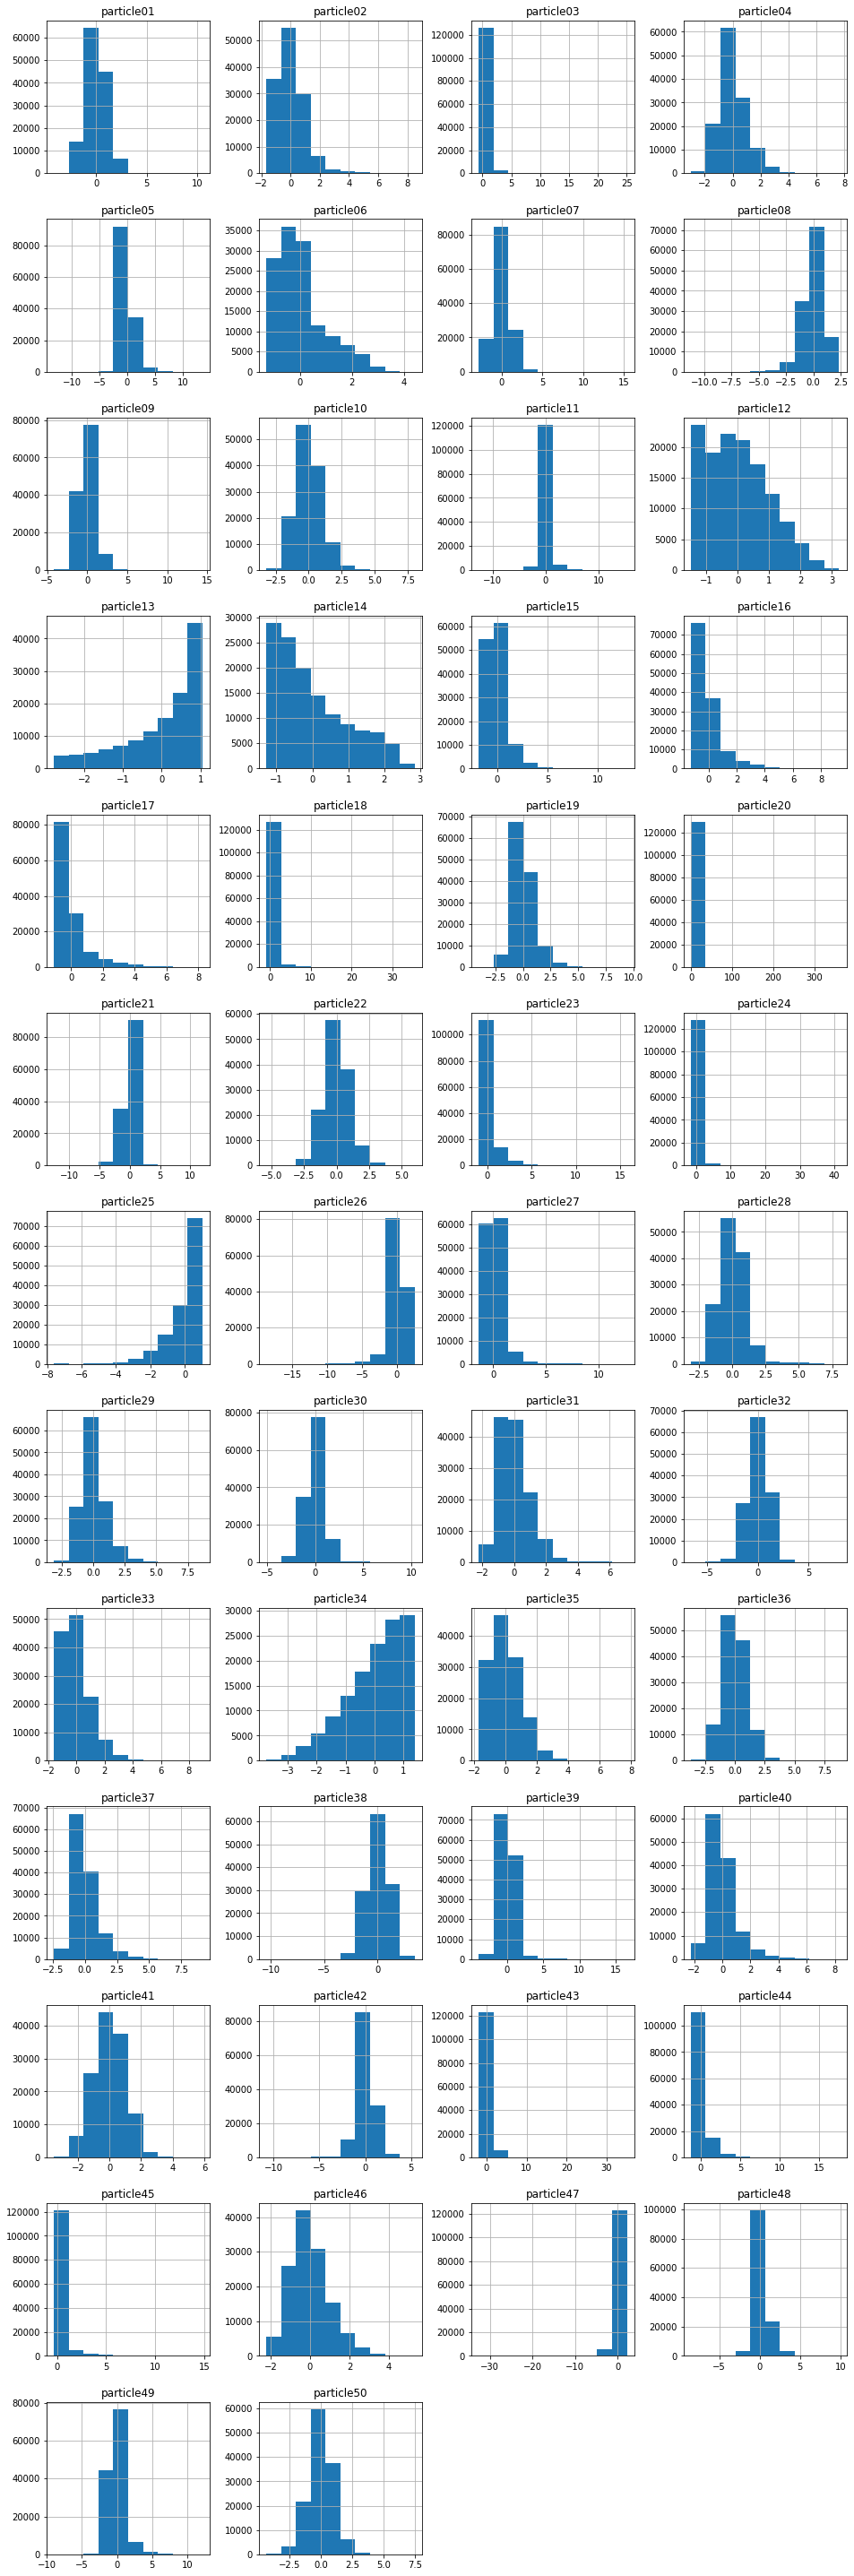

In [70]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

### 3.b) Splitting Data into Training and Test Sets

In [71]:
# Split the data further into training and test datasets
if (splitDataset):
    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=splitPercentage, 
                                                                    stratify=y_original, random_state=seedNum)
else:
    X_train_df, y_train_df = X_original, y_original
    X_test_df, y_test_df = X_original, y_original
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (97197, 50) y_train_df.shape: (97197,)
X_test_df.shape: (32399, 50) y_test_df.shape: (32399,)


### 3.c) Feature Selection

In [72]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [73]:
# Finalize the training and testing datasets for the modeling activities
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_train.shape: (97197, 50) y_train.shape: (97197,)
X_test.shape: (32399, 50) y_test.shape: (32399,)


In [74]:
if (notifyStatus): email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate one linear, two non-linear and four ensemble algorithms:

Linear Algorithm: Logistic Regression

Non-Linear Algorithms: Decision Trees (CART) and k-Nearest Neighbors

Ensemble Algorithms: Bagged CART, Random Forest, Extra Trees, and Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

In [75]:
if (notifyStatus): email_notify("Model and Evaluate Algorithms has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [76]:
startTimeModule = datetime.now()

pipeline_optimizer = TPOTClassifier()
tpot = TPOTClassifier(generations=20, population_size=50, verbosity=3, cv=n_folds, scoring=scoring, n_jobs=n_jobs, random_state=seedNum)
tpot.fit(X_train, y_train)
print('Best pipeline found using:')
print(tpot.fitted_pipeline_)
print('Accuracy metric from the test dataset using the best algorithm:',tpot.score(X_test, y_test))

print ('Total training time for automated algorithm search:',(datetime.now() - startTimeModule))

30 operators have been imported by TPOT.


Skipped pipeline #2 due to time out. Continuing to the next pipeline.
Skipped pipeline #4 due to time out. Continuing to the next pipeline.
Skipped pipeline #7 due to time out. Continuing to the next pipeline.
Skipped pipeline #11 due to time out. Continuing to the next pipeline.
Skipped pipeline #14 due to time out. Continuing to the next pipeline.
Skipped pipeline #16 due to time out. Continuing to the next pipeline.
Skipped pipeline #18 due to time out. Continuing to the next pipeline.
Skipped pipeline #21 due to time out. Continuing to the next pipeline.
Skipped pipeline #23 due to time out. Continuing to the next pipeline.
Skipped pipeline #26 due to time out. Continuing to the next pipeline.
Skipped pipeline #30 due to time out. Continuing to the next pipeline.
Skipped pipeline #32 due to time out. Continuing to the next pipeline.
Skipped pipeline #38 due to time out. Continuing to the next pipeline.
Skipped pipeline #40 due to time out. Continuing to the next pipeline.
Skipped p

In [77]:
if (notifyStatus): email_notify("Model and Evaluate Algorithms completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [78]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 16:44:35.604729
